# SYDE 556/750 --- Assignment 3
**Student ID: 21050969**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_03/syde556_assignment_03.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Decoding from a population

**a) Tuning curves.** Plot the tuning curves (firing rate of each neuron for different $x$ values between $-2$ and $2$).

In [2]:
# ✍ From assignment 1
def LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, N, tau_ref, tau_RC):
    denominator = np.zeros(N)
    alpha_arr  = np.zeros(N)
    J_bias_arr = np.zeros(N)
    
    for i in range(N):
        denominator[i] = (2 - xi_arr[i]*encoders_arr[i])*(1 - np.exp((tau_ref*a_max_arr[i] - 1)/(tau_RC * a_max_arr[i])))
        alpha_arr[i] = 1/denominator[i] -1/(2 - xi_arr[i]*encoders_arr[i])
        J_bias_arr[i] = 1 - alpha_arr[i]*xi_arr[i]*encoders_arr[i]
    return alpha_arr, J_bias_arr

def LIF_init_A(N,x_scale,tau_ref, tau_RC, alpha_arr, J_bias_arr, encoders_arr):
    M = len(x_scale)
    A = np.zeros([N,M])

    for i in range(N):
        for j in range (M):
            l =  alpha_arr[i]*x_scale[j]*encoders_arr[i] + J_bias_arr[i]
            a = 0
            if(l > 1):
                a = np.float_power(tau_ref - (tau_RC*np.log(1-np.float_power(l,-1))),-1)
            A[i][j] = a      
    return A

def init_rates_for_neuron(x_scale,tau_ref, tau_RC, alpha, J_bias, encoder):
    M = len(x_scale)
    A = np.zeros(M)

    for j in range (M):
        l =  alpha*x_scale[j]*encoder + J_bias
        a = 0
        if(l > 1):
            a = np.float_power(tau_ref - (tau_RC*np.log(1-np.float_power(l,-1))),-1)
        A[j] = a      
    return A

def plot_A(A,x_scale):
    N = len(A)
    plt.figure(figsize=(5,5))
    for i in range(N):
        plt.plot(x_scale,A[i])
    plt.title("Population Tuning Curves")
    plt.ylabel("Firing Rate (Hz)")
    plt.xlabel("Represented value x")
    plt.xlim(-2,2);
    plt.ylim(0,200)
    
def init_noisy_A(A,sigma):
    noise_of_A = np.random.normal(0,sigma,np.shape(A))
    return A + noise_of_A

def decoder(A, X, sigma,f=lambda x: x) :
    A_t = np.transpose(A)
    N = sum(len(np.array([x])) for x in X)
    M = len(A)
    d = np.dot(np.dot(np.linalg.inv(np.dot(A, A_t) + N*(sigma)**2*np.identity(M)),A),f(X))
    return d

def evaluate_decoding_errors(d,A,x_scale):
    x_est = np.dot(d,A)
    error = x_est - x_scale

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
    fig.tight_layout(pad=5.0)
    ax1.plot(x_scale,x_scale  ,label ="x")
    ax1.plot(x_scale,x_est,label ="x'")
    ax1.title.set_text('Ideal and Decoded Value')
    ax1.set_xlabel('Represented value x')
    ax1.set_ylabel("Decoded value x'")

    ax2.plot(x_scale,error,label ="x' - x")
    ax2.title.set_text('Error after Decoding')
    ax2.set_xlabel('Represented value x')
    ax2.set_ylabel("Error  x' - x")

    #mean squared error
    e = np.sqrt(np.average(np.power(error,2)))
    return e

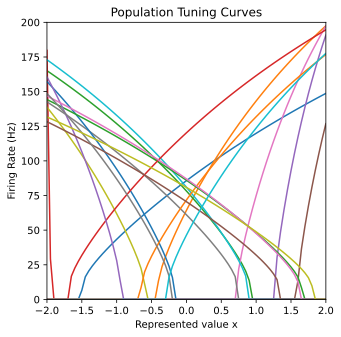

In [3]:
N = 20
steps = 81
tau_ref = 0.002
tau_RC = 0.02
x_scale = np.linspace(-2,2 ,steps)
a_max_arr = np.random.uniform(100,200,N)
xi_arr = np.random.uniform(-2,2,N)
encoders_arr = np.random.choice([-1,1],N)
alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, N, tau_ref, tau_RC)

A = LIF_init_A(N,x_scale,tau_ref, tau_RC, alpha_arr, J_bias_arr,encoders_arr)
plot_A(A,x_scale)

**b) Decoder and error computation.** Compute the decoders and plot $(x-\hat{x})$. When computing decoders, take into account noise ($\sigma=0.1 \cdot 200\,\mathrm{Hz}$). When computing $\hat{x}$, add random Gaussian noise with $\sigma=0.1 \cdot 200\,\mathrm{Hz}$ to the activity. Report the Root Mean-Squared Error (RMSE).

(20,)
RMSE: 

0.10920640446286232


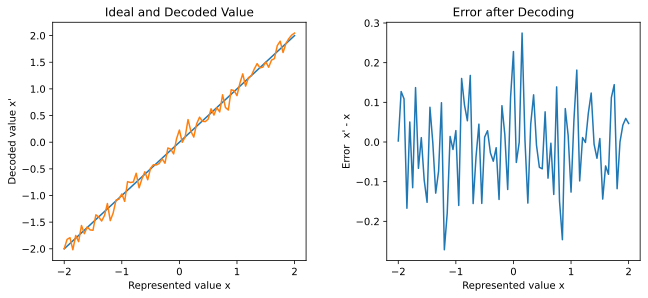

In [4]:
# ✍ 
sigma = 0.1*200
d = decoder(A,x_scale,sigma)
A_with_noise = init_noisy_A(A,sigma)
e = evaluate_decoding_errors(d,A_with_noise,x_scale)
print('RMSE: \n')
print(e)

# 2. Decoding from two spiking neurons

**a) Synaptic filter.** Plot the post-synaptic current
		$$
			h(t)= \begin{cases}
				0 & \text{if } t < 0 \,, \\
				\frac{e^{-t/\tau}}{\int_0^\infty e^{-t'/\tau} \mathrm{d}t'} & \text{otherwise} \,.
			\end{cases}
		$$

In [5]:
# ✍ From assignment 2
def simulate_spikes(encoder, tau_ref, tau_RC, J_bias, alpha, x, dt):
    num_samples = len(x)
    voltages = np.zeros(num_samples)
    refractory_period = int(tau_ref / dt)
    refractory_countdown = 0
    
    for i in range(num_samples - 1):
        voltages[i + 1] = voltages[i] + (dt * (alpha * np.dot(x[i], encoder) + J_bias - voltages[i]))/tau_RC 
        if voltages[i + 1] < 0:
            voltages[i + 1] = 0
        elif refractory_countdown > 0:
            voltages[i + 1] = 0
            refractory_countdown -= 1
        elif voltages[i + 1] >= 1:
            voltages[i + 1] = 1
            refractory_countdown = refractory_period
  
    spikes = [1 if voltage1 >= 1 else 0 for voltage1 in voltages]
    return voltages, spikes

def n_spikes(encoders, tau_ref, tau_RC, J_bias, alpha, x, dt):
    assert (len(encoders) == len(J_bias))
    assert (len(encoders) == len(alpha))
    n = len(encoders)
    spikes_arr = []
    for j in range(n):
        voltages, spikes = simulate_spikes(encoders[j], tau_ref, tau_RC, J_bias[j], alpha[j], x, dt)
        spikes_arr.append(spikes)
    return spikes_arr

def generate_signal(T, dt, rms,limit, seed):  
    np.random.seed(seed)    
    ts = np.arange(0,T,dt)
    N = len(ts)
    fr = np.fft.fftfreq(N, dt)
    fs = np.zeros(len(fr)).tolist()
    
    for i in range(len(fr)):
        if(abs(fr[i]) <= limit and fs[i] == 0):
            a = np.random.normal()
            b = np.random.normal()
            fs[i] = complex(a, b)
            fs[-i -1] = complex(a, -b)
    
    ts = np.fft.ifft(fs).real
    RMS = np.sqrt(np.power(ts,2).mean())
    ts = ts*(rms/RMS)
    fs = np.fft.fft(ts)
    
    sorted_indices = sorted(range(len(fr)), key=lambda i: fr[i])
    fs = [fs[i] for i in sorted_indices]
    return ts, fs

def post_synaptic_filter(tau,t,dt,n = 0):
    h=t**n*np.exp(-t/tau)
    h=h/np.sum(h*dt)
    return h

def decode(spikes, h, d):
    r = np.zeros(len(spikes[0]))
    n_spikes = len(spikes[0])
    n_h = len(h)

    for i in range(len(d)):
        for t in range(n_spikes):
            for j in range(n_h):
                if t - j >= 0:
                    r[t] += d[i] * h[j] * spikes[i][t - j]
    return r

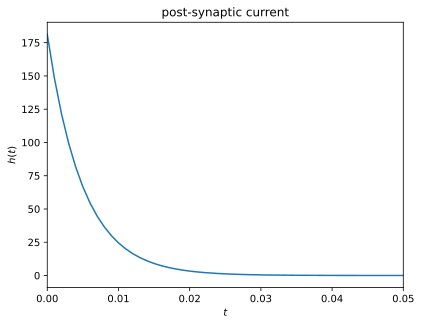

In [6]:
# ✍ 
i = np.where(x_scale == 0)[0][0]
j = np.where((A[:,i] >= 20) & (A[:,i] <= 50))[0][0] 

alpha = alpha_arr[j] 
J_bias = J_bias_arr[j]
e = [-1, 1]

T = 1
dt = 0.001
rms = 1
t = np.arange(0,T,dt)
limit = 5

ts, fs = generate_signal(T, dt, rms, limit, 17277)

voltages1, spikes1 = simulate_spikes(e[0], tau_ref, tau_RC, J_bias, alpha, ts, dt)
voltages2, spikes2 = simulate_spikes(e[1], tau_ref, tau_RC, J_bias, alpha, ts, dt)

tau = 0.005
h = post_synaptic_filter(tau,t, dt)
plt.plot(t,h)
plt.title("post-synaptic current")
plt.ylabel("$h(t)$")
plt.xlabel("$t$")
plt.xlim(0,0.05);

**b) Decoding using a synaptic filter.** Plot the original signal $x(t)$, the spikes, and the decoded $\hat{x}(t)$ all on the same graph.

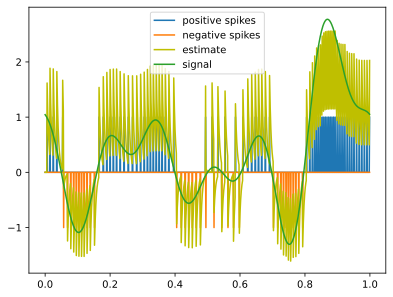

In [7]:
# ✍ 
r1 = init_rates_for_neuron(ts,tau_ref, tau_RC, alpha, J_bias, e[0])
r2 = init_rates_for_neuron(ts,tau_ref, tau_RC, alpha, J_bias, e[1])
Ar = np.array([r1,r2])
d = decoder(Ar,ts,sigma)
spikes = [spikes1,spikes2]
xest = decode(spikes,h,d)
plt.plot(t,spikes2,label='positive spikes')
spikes_n = [-1*spike for spike in spikes1]
plt.plot(t,spikes_n,label='negative spikes')
plt.plot(t,xest, label='estimate',color = 'y')
plt.plot(t,ts,label='signal')
plt.legend()
plt.show()

**c) Error analysis.** Compute the RMSE of the decoding.

In [8]:
# 
error = xest - ts
e = np.sqrt(np.average(np.power(error,2)))
print('RMSE: %s' % e)

RMSE: 0.5909440996578175


# 3. Decoding from many neurons

**a) Exploring the error for an increasing neuron count.** Plot the Root Mean-Squared Error as the number of neurons increases, on a log-log plot. Try $8$ neurons, $16$ neurons, $32$, $64$, $128$, up to $256$. For the RMSE for a particular number of neurons, average over at least $5$ randomly generated groups of neurons. For each group of neurons, randomly generate the signal $x(t)$. Use the same parameters as in question 2.

[0.4687619438686129, 0.3402597130477844, 0.27505074920349293, 0.20282978220864312, 0.17135761344321557, 0.1413630184332037]


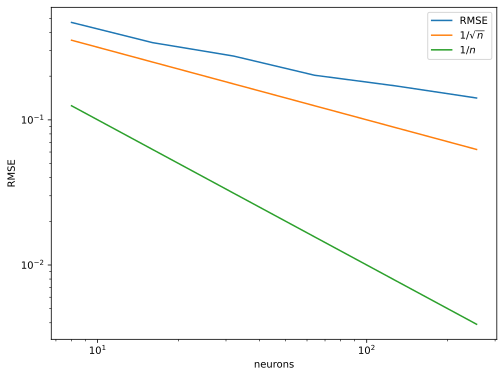

In [9]:
# ✍ 
n = 5
rms_error = []
N = [8,16,32,64,128,256]
steps = 81
tau_ref = 0.002
tau_RC = 0.02
tau = 0.005
T = 1
dt = 0.001
rms = 1
t = np.arange(0,T,dt)
limit = 5
sigma = 0.1*200
h = post_synaptic_filter(tau,t, dt)

for neurons_num in N:
    error = []
    for i in range(n):  
        ts, fs = generate_signal(T, dt, rms, limit, np.random.randint(100,1000))      
        a_max_arr = np.random.uniform(100,200,neurons_num)
        xi_arr = np.random.uniform(-2,2,neurons_num)
        encoders_arr = np.random.choice([-1,1],neurons_num)
        alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, neurons_num,\
                                                          tau_ref, tau_RC)   
        An = LIF_init_A(neurons_num,ts,tau_ref, tau_RC, alpha_arr, J_bias_arr,encoders_arr)
        
        spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, ts, dt)
        d = decoder(An,ts,sigma)
        xest = decode(spikes_arr,h,d)
        e = xest - ts
        error.append(np.sqrt(np.average(np.power(e,2))))
    rms_error.append(np.average(error))

print(rms_error)    
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.loglog(N,rms_error, label='RMSE')
ax.loglog(N,1/np.sqrt(N), label='$1/\sqrt{n}$')
ax.loglog(N,np.power(np.array(N, dtype=np.float32),-1), label='$1/n$')
ax.set_xlabel('neurons')
ax.set_ylabel('RMSE')
legend=ax.legend(loc='best') 
plt.show()

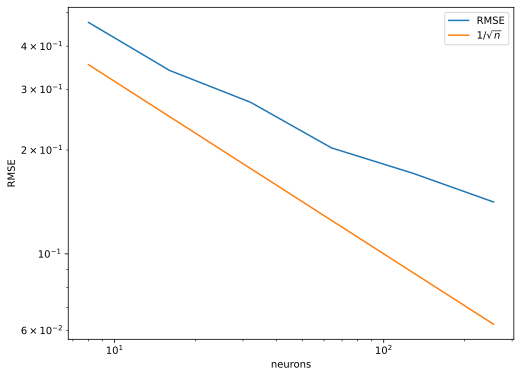

In [10]:
# to see proportion with 1/sqrt(n)
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.loglog(N,rms_error, label='RMSE')
ax.loglog(N,1/np.sqrt(N), label='$1/\sqrt{n}$')
ax.set_xlabel('neurons')
ax.set_ylabel('RMSE')
legend=ax.legend(loc='best') 
plt.show()

**b) Discussion.** Discuss your results. What is the systematic relationship between the neuron count and the error? This indicates that the decoding accuracy of the original signal increases with the number of neurons. This is an expected result, since a larger number of neurons stores more information about the original signal.

✍ The error decreases with more neurons, following a 1/sqrt(n) proportion, where n is the number of neurons. This indicates that the decoding accuracy of the original signal increases with the number of neurons. This is an expected result, since a larger number of neurons stores more information about the original signal.

# 4. Connecting two groups of neurons

**a) Computing a function.** Show the behaviour of the system with an input of $x(t)=t-1$ for $1\,\mathrm{s}$ (a linear ramp from $-1$ to $0$). Plot the ideal $x(t)$ and $y(t)$ values, along with $\hat{y}(t)$.

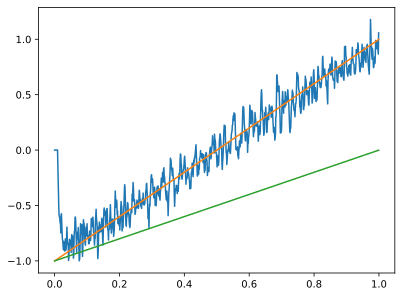

In [11]:
# ✍ 
N = 200
tau_ref=0.002
tau_RC=0.02
T=1
dt=0.001
n=0
sigma=0.1*200
t = np.arange(0,T,dt)
x_t = t - 1
y_t=2*x_t+1 # ideal  function
tau = 0.005
h = post_synaptic_filter(tau,t, dt)

f_1=lambda x: 2*x + 1
a_max_arr = np.random.uniform(100,200,N)
xi_arr = np.random.uniform(-1,1,N)
encoders_arr = np.random.choice([-1,1],N)

alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, N,tau_ref, tau_RC)   
An = LIF_init_A(N,x_t,tau_ref, tau_RC, alpha_arr, J_bias_arr,encoders_arr)
d = decoder(An,x_t,sigma,f_1)

spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, x_t, dt)
y_est = decode(spikes_arr,h,d)

f_2=lambda y: y

a_max_arr_2 = np.random.uniform(100,200,N)
xi_arr_2 = np.random.uniform(-1,1,N)
encoders_arr_2 = np.random.choice([-1,1],N)

alpha_arr_2, J_bias_arr_2 = LIF_init_alpha_and_J_bias(a_max_arr_2,xi_arr_2,encoders_arr_2, N,tau_ref, tau_RC)   
An = LIF_init_A(N,y_est,tau_ref, tau_RC, alpha_arr_2, J_bias_arr_2,encoders_arr_2)
d_2 = decoder(An,y_est,sigma,f_2)

spikes_arr_2 = n_spikes(encoders_arr_2, tau_ref, tau_RC, J_bias_arr_2, alpha_arr_2, y_est, dt)
y_est2 = decode(spikes_arr_2,h,d_2)

plt.plot(t,y_est2)
plt.plot(t,y_t)
plt.plot(t,x_t)

In [12]:
error=np.sqrt(np.average(np.power(y_est2 - y_t,2)))
print('RMSE: \n')
print(error)

RMSE: 

0.15378777467104107


**b) Step input.** Repeat part (a) with an input that is ten randomly chosen values between -1 and 0, each one held for 0.1 seconds (a randomly varying step input)

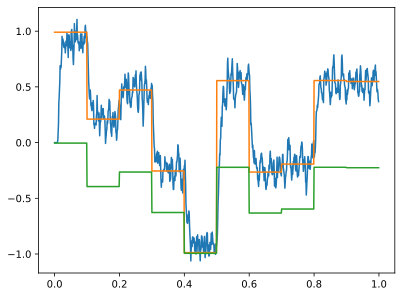

In [13]:
# ✍ 
step_values = [np.random.uniform(-1, 0) for _ in range(10)] 
step_input = []

for value in step_values:
        num_samples = int(1 / 0.01)
        step_input.extend([value] * num_samples)
        
N = 200
tau_ref=0.002
tau_RC=0.02
T=1
dt=0.001
n=0
tau = 0.005
sigma=0.1*200
t = np.arange(0,T,dt)

step_values = [np.random.uniform(-1, 0) for _ in range(10)] 
x_t = []
for value in step_values:
        x_t.extend([value] * 100)
x_t = np.array(x_t)
y_t=2*x_t+1 # ideal  function
h = post_synaptic_filter(tau,t, dt)

f_1=lambda x: 2*x + 1
a_max_arr = np.random.uniform(100,200,N)
xi_arr = np.random.uniform(-1,1,N)
encoders_arr = np.random.choice([-1,1],N)

alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, N,tau_ref, tau_RC)   
An = LIF_init_A(N,x_t,tau_ref, tau_RC, alpha_arr, J_bias_arr,encoders_arr)
d = decoder(An,x_t,sigma,f_1)

spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, x_t, dt)
y_est = decode(spikes_arr,h,d)

f_2=lambda y: y

a_max_arr_2 = np.random.uniform(100,200,N)
xi_arr_2 = np.random.uniform(-1,1,N)
encoders_arr_2 = np.random.choice([-1,1],N)

alpha_arr_2, J_bias_arr_2 = LIF_init_alpha_and_J_bias(a_max_arr_2,xi_arr_2,encoders_arr_2, N,tau_ref, tau_RC)   
An = LIF_init_A(N,y_est,tau_ref, tau_RC, alpha_arr_2, J_bias_arr_2,encoders_arr_2)
d_2 = decoder(An,y_est,sigma,f_2)

spikes_arr_2 = n_spikes(encoders_arr_2, tau_ref, tau_RC, J_bias_arr_2, alpha_arr_2, y_est, dt)
y_est2 = decode(spikes_arr_2,h,d_2)

plt.plot(t,y_est2)
plt.plot(t,y_t)
plt.plot(t,x_t)

In [14]:
error=np.sqrt(np.average(np.power(y_est2 - y_t,2)))
print('RMSE: \n')
print(error)

RMSE: 

0.22991729346322295


**c) Sinusoidal input.** Repeat part (a) with an input that is $x(t)=0.2\sin(6\pi t)$.

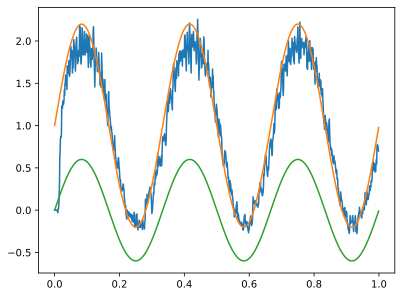

In [15]:
 # ✍ 
N = 200
tau_ref=0.002
tau_RC=0.02
T=1
dt=0.001
n=0
sigma=0.1*200
t = np.arange(0,T,dt)
x_t = 0.6*np.sin(6*np.pi*t)
y_t=2*x_t+1 # ideal  function
tau = 0.005
h = post_synaptic_filter(tau,t, dt)

f_1=lambda x: 2*x + 1
a_max_arr = np.random.uniform(100,200,N)
xi_arr = np.random.uniform(-1,1,N)
encoders_arr = np.random.choice([-1,1],N)

alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, N,tau_ref, tau_RC)   
An = LIF_init_A(N,x_t,tau_ref, tau_RC, alpha_arr, J_bias_arr,encoders_arr)
d = decoder(An,x_t,sigma,f_1)

spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, x_t, dt)
y_est = decode(spikes_arr,h,d)

f_2=lambda y: y

a_max_arr_2 = np.random.uniform(100,200,N)
xi_arr_2 = np.random.uniform(-1,1,N)
encoders_arr_2 = np.random.choice([-1,1],N)

alpha_arr_2, J_bias_arr_2 = LIF_init_alpha_and_J_bias(a_max_arr_2,xi_arr_2,encoders_arr_2, N,tau_ref, tau_RC)   
An = LIF_init_A(N,y_est,tau_ref, tau_RC, alpha_arr_2, J_bias_arr_2,encoders_arr_2)
d_2 = decoder(An,y_est,sigma,f_2)

spikes_arr_2 = n_spikes(encoders_arr_2, tau_ref, tau_RC, J_bias_arr_2, alpha_arr_2, y_est, dt)
y_est2 = decode(spikes_arr_2,h,d_2)

plt.plot(t,y_est2)
plt.plot(t,y_t)
plt.plot(t,x_t)

In [16]:
error=np.sqrt(np.average(np.power(y_est2 - y_t,2)))
print('RMSE: \n')
print(error)

RMSE: 

0.23765762015075792


**d) Discussion.** Briefly discuss the results for this question. Does the output match the ideal output? What kind of deviations do you see and why do those exist?

✍ The estimation error comes from two main issues: a delay caused by the synaptic filter and neurons reaching their capacity, which makes their tuning curves flat and reduces their activity. This affects the activity matrix, which, in turn, impacts the decoders and the final estimate's strength.

# 5. Connecting three groups of neurons

**a) Sinusoidal input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for an input of $x(t)=\cos(3\pi t)$ and $y(t)=0.5 \sin (2 \pi t)$ (over $1\,\mathrm{s}$).

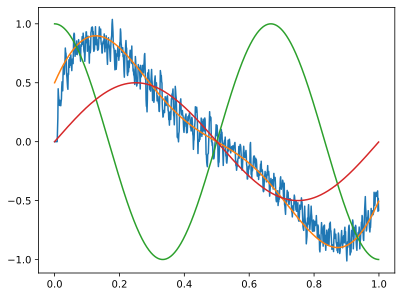

In [17]:
# 
N = 200
tau_ref=0.002
tau_RC=0.02
T=1
dt=0.001
n=0
sigma=0.1*200
t = np.arange(0,T,dt)

x_t = np.cos(3*np.pi*t)
y_t= 0.5*np.sin(2*np.pi*t)
z_t = 0.5 * x_t + 2 * y_t

tau = 0.005
h = post_synaptic_filter(tau,t, dt)

f_1=lambda x: 0.5 * x
a_max_arr = np.random.uniform(100,200,N)
xi_arr = np.random.uniform(-1,1,N)
encoders_arr = np.random.choice([-1,1],N)

alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, N,tau_ref, tau_RC)   
An = LIF_init_A(N,x_t,tau_ref, tau_RC, alpha_arr, J_bias_arr,encoders_arr)
d = decoder(An,x_t,sigma,f_1)

spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, x_t, dt)
x_est = decode(spikes_arr,h,d)

f_2=lambda y: 2*y
a_max_arr_2 = np.random.uniform(100,200,N)
xi_arr_2 = np.random.uniform(-1,1,N)
encoders_arr_2 = np.random.choice([-1,1],N)

alpha_arr_2, J_bias_arr_2 = LIF_init_alpha_and_J_bias(a_max_arr_2,xi_arr_2,encoders_arr_2, N,tau_ref, tau_RC)   
An = LIF_init_A(N,y_t,tau_ref, tau_RC, alpha_arr_2, J_bias_arr_2,encoders_arr_2)
d_2 = decoder(An,y_t,sigma,f_2)

spikes_arr_2 = n_spikes(encoders_arr_2, tau_ref, tau_RC, J_bias_arr_2, alpha_arr_2, y_t, dt)
y_est = decode(spikes_arr_2,h,d_2)

f_3=lambda z: z
z_pre = x_est + y_est
a_max_arr_3 = np.random.uniform(100,200,N)
xi_arr_3 = np.random.uniform(-1,1,N)
encoders_arr_3 = np.random.choice([-1,1],N)

alpha_arr_3, J_bias_arr_3 = LIF_init_alpha_and_J_bias(a_max_arr_3,xi_arr_3,encoders_arr_3, N,tau_ref, tau_RC)   
An = LIF_init_A(N,z_pre,tau_ref, tau_RC, alpha_arr_3, J_bias_arr_3,encoders_arr_3)
d_3 = decoder(An,z_pre,sigma,f_3)

spikes_arr_3 = n_spikes(encoders_arr_3, tau_ref, tau_RC, J_bias_arr_3, alpha_arr_3, z_pre, dt)
z_est = decode(spikes_arr_3,h,d_3)

plt.plot(t,z_est)
plt.plot(t,z_t)
plt.plot(t,x_t)
plt.plot(t,y_t)

**b) Random input.** Plot $x(t)$, $y(t)$, the ideal $z(t)$, and the decoded $\hat{z}(t)$ for a random input over $1\,\mathrm{s}$. For $x(t)$ use a random signal with a limit of $8\,\mathrm{Hz}$ and $\mathtt{rms}=1$. For $y(t)$ use a random signal with a limit of $5\,\mathrm{Hz}$ and $\mathtt{rms}=0.5$.

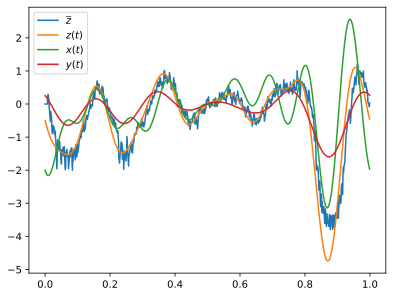

In [18]:
# 
N = 200
tau_ref=0.002
tau_RC=0.02
T=1
dt=0.001
n=0
sigma=0.1*200
t = np.arange(0,T,dt)

x_t = generate_signal(T, dt, 1, 8, 8777)[0]
x_t = np.array(x_t)
y_t= generate_signal(T, dt, 0.5, 5, 17787)[0]
y_t = np.array(y_t)
z_t = 0.5*x_t + 2 * y_t

tau = 0.005
h = post_synaptic_filter(tau,t, dt)

f_1=lambda x: x/2
a_max_arr = np.random.uniform(100,200,N)
xi_arr = np.random.uniform(-1,1,N)
encoders_arr = np.random.choice([-1,1],N)

alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias(a_max_arr,xi_arr,encoders_arr, N,tau_ref, tau_RC)   
An = LIF_init_A(N,x_t,tau_ref, tau_RC, alpha_arr, J_bias_arr,encoders_arr)
d = decoder(An,x_t,sigma,f_1)

spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, x_t, dt)
x_est = decode(spikes_arr,h,d)

f_2=lambda y: 2*y
a_max_arr_2 = np.random.uniform(100,200,N)
xi_arr_2 = np.random.uniform(-1,1,N)
encoders_arr_2 = np.random.choice([-1,1],N)

alpha_arr_2, J_bias_arr_2 = LIF_init_alpha_and_J_bias(a_max_arr_2,xi_arr_2,encoders_arr_2, N,tau_ref, tau_RC)   
An = LIF_init_A(N,y_t,tau_ref, tau_RC, alpha_arr_2, J_bias_arr_2,encoders_arr_2)
d_2 = decoder(An,y_t,sigma,f_2)

spikes_arr_2 = n_spikes(encoders_arr_2, tau_ref, tau_RC, J_bias_arr_2, alpha_arr_2, y_t, dt)
y_est = decode(spikes_arr_2,h,d_2)

f_3=lambda z: z
z_pre = x_est + y_est
a_max_arr_3 = np.random.uniform(100,200,N)
xi_arr_3 = np.random.uniform(-1,1,N)
encoders_arr_3 = np.random.choice([-1,1],N)

alpha_arr_3, J_bias_arr_3 = LIF_init_alpha_and_J_bias(a_max_arr_3,xi_arr_3,encoders_arr_3, N,tau_ref, tau_RC)   
An = LIF_init_A(N,z_pre,tau_ref, tau_RC, alpha_arr_3, J_bias_arr_3,encoders_arr_3)
d_3 = decoder(An,z_pre,sigma,f_3)

spikes_arr_3 = n_spikes(encoders_arr_3, tau_ref, tau_RC, J_bias_arr_3, alpha_arr_3, z_pre, dt)
z_est = decode(spikes_arr_3,h,d_3)

plt.plot(t,z_est, label = "$\overline{z}$")
plt.plot(t,z_t,  label = "$z(t)$")
plt.plot(t,x_t , label = "$x(t)$")
plt.plot(t,y_t,  label = "$y(t)$")
plt.legend()

# 6. Computing with vectors

**a) Constant inputs.** Plot the decoded output $\hat{w}(t)$ and the ideal $w$ for
		$$x =(0.5,1), \quad y = (0.1,0.3), \quad z =(0.2,0.1), \quad q = (0.4,-0.2) \,.$$

In [19]:
# ✍ 
def LIF_init_alpha_and_J_bias_2D(a_max_arr,xi_arr,encoders_arr, N, tau_ref, tau_RC):
    denominator = np.zeros(N)
    alpha_arr  = np.zeros(N)
    J_bias_arr = np.zeros(N)
    
    for i in range(N):
        denominator[i] = (2 - np.dot(xi_arr[i],encoders_arr[i]))*(1 - np.exp((tau_ref*a_max_arr[i] - 1)/(tau_RC * a_max_arr[i])))
        alpha_arr[i] = 1/denominator[i] -1/(2 - np.dot(xi_arr[i],encoders_arr[i]))
        J_bias_arr[i] = 1 - alpha_arr[i]*np.dot(xi_arr[i],encoders_arr[i])
    return alpha_arr, J_bias_arr

def init_2D_A(N, coords, encoders_arr, tau_rc, tau_ref, alpha_arr, J_bias_arr):
    A = np.zeros([N,len(coords)])   
    for i in range(N): 
        for j in range(len(coords)):
            l = alpha_arr[i]*np.dot(coords[j],encoders_arr[i]) + J_bias_arr[i]
            a = 0
            if (l > 1):
                a = np.float_power(tau_ref - (tau_RC*np.log(1-np.float_power(l,-1))),-1)
            A[i][j] = a 
    return A

def decode_2d(spikes, h, d):
    timesteps = len(spikes[0])
    n_neurons = len(d)
    dimension = len(d[0])
    xhat = np.zeros((timesteps, dimension))

    for i in range(n_neurons):
        decoder = d[i]
        filtered_spikes = np.zeros((timesteps,))

        for j in range(timesteps):
            for k in range(len(h)):
                if j - k >= 0:
                    filtered_spikes[j] += spikes[i][j - k] * h[k]

        filtered_spikes = filtered_spikes.reshape(timesteps, 1)
        value = filtered_spikes * decoder
        xhat += value

    return xhat

In [20]:
N = 200
tau_ref=0.002
tau_RC=0.02
steps = 41
T=1
dt=0.001
n=0
sigma=0.1*200
t = np.arange(0,T,dt)
x = np.linspace(-1,1,steps)
y = np.linspace(-1,1,steps)
coords =[]
for i in range(len(x)):
    for j in range(len(y)):
        coords.append([x[i],y[j]])

tau = 0.005
h = post_synaptic_filter(tau,t, dt)

x_t = np.full((len(t), 2), [0.5, 1])
y_t = np.full((len(t), 2), [0.1, 0.3])
z_t = np.full((len(t), 2), [0.2, 0.1])
q_t = np.full((len(t), 2), [0.4, -0.2])
# w = x − 3y + 2z − 2q
w_t = x_t - 3 * y_t + 2 * z_t - 2 * q_t


#x
angles = np.random.uniform(0,2*np.pi,N)
encoders_arr = np.array([(np.cos(angles)[i],np.sin(angles)[i]) for i in range(len(angles))])
xi_arr=np.array([np.random.uniform(-1,1)*encoders_arr[i] for i in range(len(encoders_arr))])
a_max_arr = np.random.uniform(100,200,N)

alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias_2D(a_max_arr,xi_arr,encoders_arr, N, tau_ref, tau_RC)
Ad = init_2D_A(N, coords, encoders_arr, tau_RC, tau_ref, alpha_arr, J_bias_arr)
d = decoder(Ad,coords,sigma)
spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, x_t, dt)
x_est = decode_2d(spikes_arr,h,d)

#y
angles2 = np.random.uniform(0,2*np.pi,N)
encoders_arr2 = np.array([(np.cos(angles2)[i],np.sin(angles2)[i]) for i in range(len(angles2))])
xi_arr2=np.array([np.random.uniform(-1,1)*encoders_arr2[i] for i in range(len(encoders_arr2))])
a_max_arr2 = np.random.uniform(100,200,N)

alpha_arr2, J_bias_arr2 = LIF_init_alpha_and_J_bias_2D(a_max_arr2,xi_arr2,encoders_arr2, N, tau_ref, tau_RC)
Ad2 = init_2D_A(N, coords, encoders_arr2, tau_RC, tau_ref, alpha_arr2, J_bias_arr2)
d2 = decoder(Ad2,coords,sigma)
spikes_arr2 = n_spikes(encoders_arr2, tau_ref, tau_RC, J_bias_arr2, alpha_arr2, y_t, dt)
y_est = decode_2d(spikes_arr2,h,d2)

#z
angles3 = np.random.uniform(0,2*np.pi,N)
encoders_arr3 = np.array([(np.cos(angles3)[i],np.sin(angles3)[i]) for i in range(len(angles3))])
xi_arr3=np.array([np.random.uniform(-1,1)*encoders_arr3[i] for i in range(len(encoders_arr3))])
a_max_arr3 = np.random.uniform(100,200,N)

alpha_arr3, J_bias_arr3 = LIF_init_alpha_and_J_bias_2D(a_max_arr3,xi_arr3,encoders_arr3, N, tau_ref, tau_RC)
Ad3 = init_2D_A(N, coords, encoders_arr3, tau_RC, tau_ref, alpha_arr3, J_bias_arr3)
d3 = decoder(Ad3,coords,sigma)
spikes_arr3 = n_spikes(encoders_arr3, tau_ref, tau_RC, J_bias_arr3, alpha_arr3, z_t, dt)
z_est = decode_2d(spikes_arr3,h,d3)

#q
angles4 = np.random.uniform(0,2*np.pi,N)
encoders_arr4 = np.array([(np.cos(angles4)[i],np.sin(angles4)[i]) for i in range(len(angles4))])
xi_arr4 = np.array([np.random.uniform(-1,1)*encoders_arr4[i] for i in range(len(encoders_arr4))])
a_max_arr4 = np.random.uniform(100,200,N)

alpha_arr4, J_bias_arr4 = LIF_init_alpha_and_J_bias_2D(a_max_arr4, xi_arr4, encoders_arr4, N, tau_ref, tau_RC)
Ad4 = init_2D_A(N, coords, encoders_arr4, tau_RC, tau_ref, alpha_arr4, J_bias_arr4)
d4 = decoder(Ad4,coords,sigma)
spikes_arr4 = n_spikes(encoders_arr4, tau_ref, tau_RC, J_bias_arr4, alpha_arr4, q_t, dt)
q_est = decode_2d(spikes_arr4,h,d4)

#w
w_pre = x_est - 3* y_est + 2*z_est -2* q_est
angles5 = np.random.uniform(0,2*np.pi,N)
encoders_arr5 = np.array([(np.cos(angles5)[i],np.sin(angles5)[i]) for i in range(len(angles5))])
xi_arr5 = np.array([np.random.uniform(-1,1)*encoders_arr5[i] for i in range(len(encoders_arr5))])
a_max_arr5 = np.random.uniform(100,200,N)

alpha_arr5, J_bias_arr5 = LIF_init_alpha_and_J_bias_2D(a_max_arr5, xi_arr5, encoders_arr5, N, tau_ref, tau_RC)
Ad5 = init_2D_A(N, coords, encoders_arr5, tau_RC, tau_ref, alpha_arr5, J_bias_arr5)
d5 = decoder(Ad5,coords,sigma)
spikes_arr5 = n_spikes(encoders_arr5, tau_ref, tau_RC, J_bias_arr5, alpha_arr5, w_pre, dt)
w_est = decode_2d(spikes_arr5,h,d5)

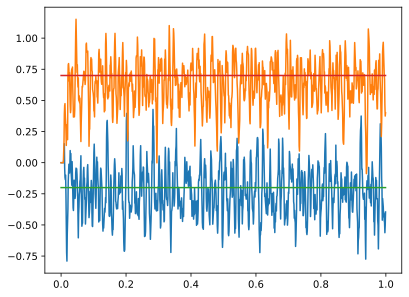

In [21]:
plt.plot(t,w_est, label = "$\overline{w}$")
plt.plot(t,w_t, label = "w_t")

**b) Sinusoidal input.** Produce the same plot for
$$x =(0.5,1), \quad y = (\sin(4\pi t),0.3), \quad z =(0.2,0.1), \quad q = (\sin(4\pi t),-0.2) \,.$$

In [22]:
# ✍ 
N = 200
tau_ref=0.002
tau_RC=0.02
steps = 41
T=1
dt=0.001
n=0
sigma=0.1*200
t = np.arange(0,T,dt)
x = np.linspace(-1,1,steps)
y = np.linspace(-1,1,steps)
coords =[]
for i in range(len(x)):
    for j in range(len(y)):
        coords.append([x[i],y[j]])

tau = 0.005
h = post_synaptic_filter(tau,t, dt)

x_t = np.full((len(t), 2), [0.5, 1])
y_t = np.array([[np.sin(4 * np.pi * ti), 0.3] for ti in t])
z_t = np.full((len(t), 2), [0.2, 0.1])
q_t = np.array([[np.sin(4 * np.pi * ti), -0.2] for ti in t])
# w = x − 3y + 2z − 2q
w_t = x_t - 3 * y_t + 2 * z_t - 2 * q_t


#x
angles = np.random.uniform(0,2*np.pi,N)
encoders_arr = np.array([(np.cos(angles)[i],np.sin(angles)[i]) for i in range(len(angles))])
xi_arr=np.array([np.random.uniform(-1,1)*encoders_arr[i] for i in range(len(encoders_arr))])
a_max_arr = np.random.uniform(100,200,N)

alpha_arr, J_bias_arr = LIF_init_alpha_and_J_bias_2D(a_max_arr,xi_arr,encoders_arr, N, tau_ref, tau_RC)
Ad = init_2D_A(N, coords, encoders_arr, tau_RC, tau_ref, alpha_arr, J_bias_arr)
d = decoder(Ad,coords,sigma)
spikes_arr = n_spikes(encoders_arr, tau_ref, tau_RC, J_bias_arr, alpha_arr, x_t, dt)
x_est = decode_2d(spikes_arr,h,d)

#y
angles2 = np.random.uniform(0,2*np.pi,N)
encoders_arr2 = np.array([(np.cos(angles2)[i],np.sin(angles2)[i]) for i in range(len(angles2))])
xi_arr2=np.array([np.random.uniform(-1,1)*encoders_arr2[i] for i in range(len(encoders_arr2))])
a_max_arr2 = np.random.uniform(100,200,N)

alpha_arr2, J_bias_arr2 = LIF_init_alpha_and_J_bias_2D(a_max_arr2,xi_arr2,encoders_arr2, N, tau_ref, tau_RC)
Ad2 = init_2D_A(N, coords, encoders_arr2, tau_RC, tau_ref, alpha_arr2, J_bias_arr2)
d2 = decoder(Ad2,coords,sigma)
spikes_arr2 = n_spikes(encoders_arr2, tau_ref, tau_RC, J_bias_arr2, alpha_arr2, y_t, dt)
y_est = decode_2d(spikes_arr2,h,d2)

#z
angles3 = np.random.uniform(0,2*np.pi,N)
encoders_arr3 = np.array([(np.cos(angles3)[i],np.sin(angles3)[i]) for i in range(len(angles3))])
xi_arr3=np.array([np.random.uniform(-1,1)*encoders_arr3[i] for i in range(len(encoders_arr3))])
a_max_arr3 = np.random.uniform(100,200,N)

alpha_arr3, J_bias_arr3 = LIF_init_alpha_and_J_bias_2D(a_max_arr3,xi_arr3,encoders_arr3, N, tau_ref, tau_RC)
Ad3 = init_2D_A(N, coords, encoders_arr3, tau_RC, tau_ref, alpha_arr3, J_bias_arr3)
d3 = decoder(Ad3,coords,sigma)
spikes_arr3 = n_spikes(encoders_arr3, tau_ref, tau_RC, J_bias_arr3, alpha_arr3, z_t, dt)
z_est = decode_2d(spikes_arr3,h,d3)

#q
angles4 = np.random.uniform(0,2*np.pi,N)
encoders_arr4 = np.array([(np.cos(angles4)[i],np.sin(angles4)[i]) for i in range(len(angles4))])
xi_arr4 = np.array([np.random.uniform(-1,1)*encoders_arr4[i] for i in range(len(encoders_arr4))])
a_max_arr4 = np.random.uniform(100,200,N)

alpha_arr4, J_bias_arr4 = LIF_init_alpha_and_J_bias_2D(a_max_arr4, xi_arr4, encoders_arr4, N, tau_ref, tau_RC)
Ad4 = init_2D_A(N, coords, encoders_arr4, tau_RC, tau_ref, alpha_arr4, J_bias_arr4)
d4 = decoder(Ad4,coords,sigma)
spikes_arr4 = n_spikes(encoders_arr4, tau_ref, tau_RC, J_bias_arr4, alpha_arr4, q_t, dt)
q_est = decode_2d(spikes_arr4,h,d4)

#w
w_pre = x_est - 3* y_est + 2*z_est -2* q_est
angles5 = np.random.uniform(0,2*np.pi,N)
encoders_arr5 = np.array([(np.cos(angles5)[i],np.sin(angles5)[i]) for i in range(len(angles5))])
xi_arr5 = np.array([np.random.uniform(-1,1)*encoders_arr5[i] for i in range(len(encoders_arr5))])
a_max_arr5 = np.random.uniform(100,200,N)

alpha_arr5, J_bias_arr5 = LIF_init_alpha_and_J_bias_2D(a_max_arr5, xi_arr5, encoders_arr5, N, tau_ref, tau_RC)
Ad5 = init_2D_A(N, coords, encoders_arr5, tau_RC, tau_ref, alpha_arr5, J_bias_arr5)
d5 = decoder(Ad5,coords,sigma)
spikes_arr5 = n_spikes(encoders_arr5, tau_ref, tau_RC, J_bias_arr5, alpha_arr5, w_pre, dt)
w_est = decode_2d(spikes_arr5,h,d5)

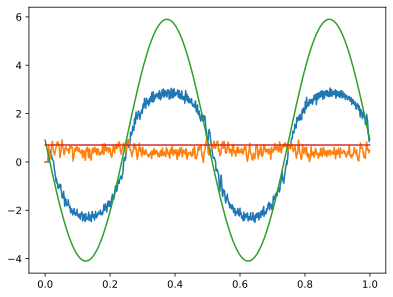

In [23]:
plt.plot(t,w_est, label = "$\overline{w}$")
plt.plot(t,w_t, label = "w_t")

In [2]:
import nengo
net = nengo.Network()
with net:
    my_ensemble = nengo.Ensemble(n_neurons=40, dimensions=1)
    my_node = nengo.Node(output=0.5)
    nengo.Connection(my_node, my_ensemble)
sim = nengo.Simulator(net)
sim.run(5.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

**c) Discussion.** Describe your results and discuss why and how they stray from the expected answer.

✍ Neurons with high activity will have a greater impact than others. They create a signal that aligns with the dimensions their decoders point to, potentially causing a systematic overestimation or underestimation of the actual signal.